# RENT applied to a binary classification problem

This Jupyter notebook illustrates how to apply RENT to your data for feature selection with a **binary classification** problem. It is also complimentary to the manscript published at arXiv.org. The example conforms with the example in the manuscript in terms of dataset, feature names and analyses.

[RENT -- Repeated Elastic Net Technique for Feature Selection](https://arxiv.org/abs/2009.12780)

For an example on how to use RENT for feature selection on a **regression problem**, please have a look this [Jupyter Notebook](https://github.com/NMBU-Data-Science/RENT/blob/master/src/RENT/Regression_example.ipynb).

## Content

1. [Load Wisconsin Breast Cancer dataset](#Load-Wisconsin-Breast-Cancer-dataset)
2. [Define RENT ensemble for binary classification](#Define-RENT-ensemble-for-binary-classification)
3. [Train RENT ensemble and inspect results](#Train-RENT-ensemble-and-inspect-results)
4. [Set selection criteria cutoffs](#Set-selection-criteria-cutoffs)
5. [Check performance using only selected features](#Check-performance-using-only-selected-features)
6. [Validation study regarding the features selected by RENT](#Validation-study-regarding-the-features-selected-by-RENT)
7. [Investigation of class predictions](#Investigation-of-class-predictions)
8. [Stability analysis of RENT](#Stability-analysis-of-RENT)

---

First we import needed modules and apply some settings to the Jupyter notebook for better visualisation of results.

In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 2000)
from RENT import RENT, stability

import warnings
warnings.filterwarnings("ignore")

### Load Wisconsin Breast Cancer dataset

Now load the data, store it in a pandas.DataFrame format. We use the Wisconsin breast cancer dataset from the UCI database (also available on scikit-learn), which we have already split into a train and test set.

In [2]:
train_data = pd.read_csv("data/wisconsin_train.csv").iloc[:,1:]
train_labels = pd.read_csv("data/wisconsin_train_labels.csv").iloc[:,1].values
test_data = pd.read_csv("data/wisconsin_test.csv").iloc[:,1:]
test_labels = pd.read_csv("data/wisconsin_test_labels.csv").iloc[:,1:].values

In [3]:
train_data.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28,F29,F30
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,12.45,15.70,82.57,477.1,0.12780,0.17000,0.1578,0.08089,0.2087,0.07613,0.3345,0.8902,2.217,27.19,0.007510,0.03345,0.03672,0.01137,0.02165,0.005082,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440
4,12.46,24.04,83.97,475.9,0.11860,0.23960,0.2273,0.08543,0.2030,0.08243,0.2976,1.5990,2.039,23.94,0.007149,0.07217,0.07743,0.01432,0.01789,0.010080,15.09,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750


### Define RENT ensemble for binary classification

**The main idea**

Using the RENT approach we will train an **ensemble of unique models** based on **unique subsets** of the training data. Since each model is trained on a unique subset, all models will be slightly different from each other and elastic net regularisation **may select a different subset of features for each model**. 

RENT investigates **how consistenly elastic net selects features** across all unique models by analysing distributions of the weight sizes of each feature. Using specific thresholds or cutoff values for selection criteria $\tau_1$, $\tau_2$ and $\tau_3$ computed from those weight size distributions, we can regulate how aggressively RENT will select features from the full set of features. For more details, please consult the paper mentioned at the top of this Juptyer notebook

**Elastic net regularisation**

$\lambda_{enet}(\beta) = \gamma [\alpha\lambda_1(\beta)+ (1-\alpha)\lambda_2(\beta)]$

Since the average prediction performance of an ensemble of models may vary for different combinations of $\gamma$ and $\alpha$ we pre-define a number of values for each and store them in lists `my_C_params` and `my_l1_ratios`. Prior to RENT, the best performing combination of $\gamma$ and $\alpha$ for prediction will be identified through 5-fold cross validation. For the best performing combination RENT will then compute an ensemble of models that will be utilised for feature selection.

**Note** regarding elastic net regularisation term above we follow the scikit-learn convention:

* RENT input paramter `C` represents inverse values of $\gamma$
* RENT input parameter `l1_ratio` represents values of $\alpha$ for the mix of L1 and L2 regularisation. `l1_ratio = 1` is equivalent to using L1-regularisation, `l1_ratio = 0` is equivalent to using L2-regularisation while values between 0 and 1 will result in a mix of L1 and L2 regularisation.

In the code below we initialise the `RENT_Classification` ensemble. In addition to various values for `C` and `l1_ratio` we can define:

* `autoEnetParSel`: whether identification of best performing `C` and `l1_ratio` should be done automatic through 5-fold cross validation (set to `True`) or if user selects manually (set to `False`)  
* `poly`: whether to include squares of features and interactions of features. Should be beneficial if data are non-linear, but comes with a computational cost that may increase very much if the number of orginal set of features is high. 
* `testsize_range`: this allows for more randomness in models by allowing test set sizes to vary within range defined in tuple (lower end, higher end). Set both parameters to the same value to secure identical test set size across for all models in ensemble.
* `scoring`: performance metric to use for model evaluation
* `classifier`: which classification algorithm to choose for model training. Uses logistic regression by default.
* `K`: how many models the ensemble should consist of. The higher the better (denser weight distributions leading to higher selection stability), but computationally more expensive.
* `random_sate`: set a seed to reproduce examples. Default: None.
* `verbose`: whether or not to show progress during computations. Choose 1 to get information on computation progress, else 0.

For more detailed information for each input parameter, please consult the documentation [link here]

In [4]:
# Define a range of regularisation parameters C for elastic net. A minimum of at least one value is required.
my_C_params = [0.1, 1, 10]

# Define a reange of l1-ratios for elastic net.  A minimum of at least one value is required.
my_l1_ratios = [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]

# Define setting for RENT
model = RENT.RENT_Classification(data=train_data, 
                                 target=train_labels, 
                                 feat_names=train_data.columns, 
                                 C=my_C_params, 
                                 l1_ratios=my_l1_ratios,
                                 autoEnetParSel=True,
                                 poly='OFF',
                                 testsize_range=(0.25,0.25),
                                 scoring='mcc',
                                 classifier='logreg',
                                 K=100,
                                 random_state = 0,
                                 verbose=1)

data dimension: (399, 30)  data type: <class 'pandas.core.frame.DataFrame'>
target dimension: (399,)
regularization parameters C: [0.1, 1, 10]
elastic net l1_ratios: [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]
poly: OFF
number of models in ensemble: 100
random state: 0
verbose: 1
classifier: logreg
scoring: mcc


### Train RENT ensemble and inspect results

Now train a RENT ensemble for the best combination of `C` and `l1_ratio`. The best has already been identified through 5-fold cross validation with `autoEnetParSel`. 

In [5]:
model.train()

If it is of interest, one can extract time (sec) for computation of all ensembles.

In [6]:
model.get_runtime()

3.6813735961914062

Acquire the elastic net parameter for which RENT was applied to the data using `.get_enet_params()`.

In [7]:
# can play around with enet parameter setting...
model.get_enet_params()

(0.1, 0.9)

For the data at hand, best parameter combination is `l1_ratio=0.1` and `C=1`.

### Set selection criteria cutoffs

Here we can set how agressively we want RENT to select features by setting thresholds or cutoff values for $\tau_1$, $\tau_2$ and $\tau_3$. 

Below we set `tau_1_cutoff = 0.9`, meaning that we will consider only features that were selected in at least 90% across the $K$ ensemble models. 

Sometimes features are selected by elastic net (weight is non-zero), but their weights might be very small. This happens more often when `l1_ratio` is such that the L2-part of the regularisation gets more influence than L1 (smaller values for `l1_ratio`). In addition, feature weights may be positive in some models and negative in others showing little consistency. This may indicate that even though such a feature is selected, it may not be very meaningful, since its feature weights are small and alternating signs. The `tau_2_cutoff` criterion simply allows the user to define a required minimum proportion of the parameter estimates to have the same sign.

`tau_3_cutoff` is chosen such that it corresponds to the well-known statistical Student’s t-test with rejection of the null hypothesis, assuming that the mean of the feature weights across all models is equal to zero. In other words, we test whether the feature weighs are consistently high with low variance across the $K$ models.

Only if the resulting values for each feature are higher than the cutoff for all three criteria, the RENT will select the feature. In the example below we set the cutoff criteria to `tau_1_cutoff=0.9`, `tau_2_cutoff=0.9`, `tau_3_cutoff=0.975`.

In [8]:
selected_features = model.selectFeatures(tau_1_cutoff=0.9, tau_2_cutoff=0.9, tau_3_cutoff=0.975)

How do we know whether a feature fulfills the criteria?

We can check this by looking at the summary for `tau_1`, `tau_2` and `tau_3` across all features using `.get_summary_criteria()`. We can see for example that RENT selects feature `F21`, since its vaues for `tau_1`, `tau_2` and `tau_3` are all 1, and therefore, above the cutoffs set in the code above. Feature `F29` gets close with `tau_1=0.84` and `tau_2=0.84`, but they are still below `tau_1_cutoff` and `tau_2_cutoff`. If we would set lower cutoffs, say `tau_1=0.8` and `tau_2=0.8` `F29` would be selected. By varying cutoffs for `tau_1`, `tau_2` and `tau_3` we can steer the strictness of feature selection.

In [9]:
model.get_summary_criteria()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28,F29,F30
tau_1,0.09000,0.10000,0.140000,0.0,0.0,0.0,0.060000,1.0,0.0,0.0,0.220000,0.0,0.0,0.02000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.54,0.95,0.0,0.090000,1.0,0.84,0.0
tau_2,0.09000,0.10000,0.140000,0.0,0.0,0.0,0.060000,1.0,0.0,0.0,0.220000,0.0,0.0,0.02000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.54,0.95,0.0,0.090000,1.0,0.84,0.0
tau_3,0.99302,0.99651,0.999229,NaN,NaN,NaN,0.986077,1.0,NaN,NaN,0.999492,NaN,NaN,0.87208,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.00,1.00,NaN,0.989063,1.0,1.00,NaN


Let's check which features were selected based on the cutoffs we defined above.

In [10]:
selected_features

array([ 7, 20, 21, 22, 24, 27])

Using the indices of the selected features we can identify the feature names.

In [11]:
train_data.columns[selected_features]

Index(['F8', 'F21', 'F22', 'F23', 'F25', 'F28'], dtype='object')

**Regarding $\tau_{1}$**

To get a better impression on how often a feature weight was non-zero across all models, we use `.plot_selection_frequency()`. The barplot shows that over all models in the ensemble, features at index 3 to 5, 8, 9, 11, 12, 14 to 19 as well as 25 and 29 were never assigned a weight unequal to 0. This means that have never been selected across all models in the ensemble. Elatic net selected some features only for a few models in the ensemble (for example features at index 0,1 or 26), that is in around 15% of the models (approx. 0.15 on the vertical axis) or lower (for example features at index 6 and 13). This indicates that the selection of these features by elastic net is relatively unstable and very dependent on the subset of the training samples. 

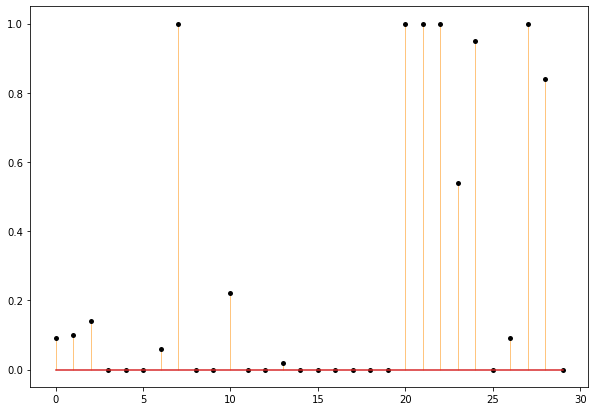

In [12]:
model.plot_selection_frequency()

**Regarding $\tau_{2}$ and $\tau_{3}$**

One has to keep in mind though, that a feature may be selected by elastic net (the weight is non-zero), but it may be:

1. very small and hence not very influential to the model (even though it was selected by elastic net)
2. alternating its sign (positive or negative weight value) across the ensemble of models, indicating unstable importance of this feature.

To get more detailed information on the weight sizes one could investigate the full distribution of the weights of each feature across all models. This is possible by calling `.get_weight_distributions()`. This returns an array holding all weights across all models in the ensemble (rows) and each feature (columns). Here we can see that for the feature `F6` the weights are always 0 across all 100 models applied in this example (corresponding to the plot above). Selecting `binary=True`, returns a binary matrix, where those postitions where weights is unequal to 0 are assigned 1.

In [13]:
model.get_weight_distributions(binary=False)

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28,F29,F30
mod 1,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,-0.595026,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-0.994814,-0.463689,-0.785331,0.000000,-0.064554,0.0,0.000000,-0.830659,-0.165898,0.0
mod 2,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,-0.723322,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-0.979506,-0.427817,-0.814736,0.000000,-0.214243,0.0,0.000000,-0.688921,-0.089303,0.0
mod 3,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,-0.580382,0.0,0.0,-0.120594,0.0,0.0,-0.008654,0.0,0.0,0.0,0.0,0.0,0.0,-0.984332,-0.502355,-0.612971,-0.066446,-0.212464,0.0,0.000000,-0.771527,-0.047361,0.0
mod 4,0.000000,-0.010166,-0.031628,0.0,0.0,0.0,0.000000,-0.745832,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-0.866859,-0.519826,-0.818621,-0.011974,-0.317814,0.0,0.000000,-0.673526,0.000000,0.0
mod 5,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,-0.704324,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-1.011314,-0.520622,-0.811410,-0.118844,-0.266318,0.0,0.000000,-0.519583,-0.133781,0.0
mod 6,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,-0.608919,0.0,0.0,-0.113463,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-0.993614,-0.491141,-0.700531,-0.051794,-0.079281,0.0,0.000000,-0.760250,-0.161145,0.0
mod 7,0.000000,-0.059813,0.000000,0.0,0.0,0.0,0.000000,-0.820021,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-0.971081,-0.377624,-0.622268,-0.161846,-0.117710,0.0,0.000000,-0.619815,-0.168948,0.0
mod 8,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,-0.508301,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-0.972652,-0.359145,-0.799350,-0.037663,-0.058220,0.0,0.000000,-1.137564,-0.028681,0.0
mod 9,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,-0.520111,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-1.085075,-0.408846,-0.760673,-0.073752,-0.191221,0.0,0.000000,-0.677481,-0.174449,0.0
mod 10,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,-0.632561,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-0.841317,-0.650940,-0.728928,0.000000,-0.186647,0.0,0.000000,-0.958409,-0.047929,0.0


We assign this array to a variable and plot weight distributions of specific feautures using histograms.

In [14]:
weight_dist = model.get_weight_distributions()

Plot the weight distribution of feature at index 27, that is `F28`. This feature is selected very often as we can see that most of the weights are different from zero and negative.

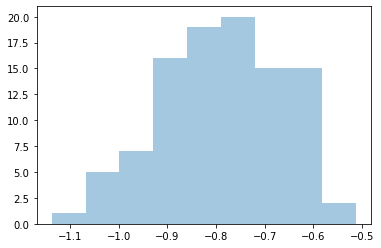

In [15]:
import seaborn as sns
ax = sns.distplot(weight_dist.values[:, 27], kde=False)

All of the weights of feature at index 15 (`F16`) are zero, meaning that this feature is not important for the model.

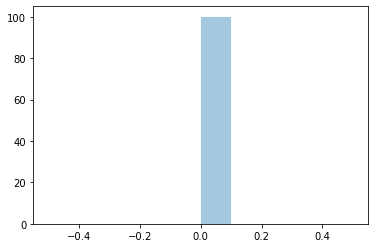

In [16]:
ax = sns.distplot(weight_dist.values[:, 15], kde=False)

With help of ``.plot_elementary_models()`` we get detailed insight into ``scores`` and ``% of zero weight`` over the ``K`` model. For each of the ``K`` (100) models, we get the exact values on the second axis. 

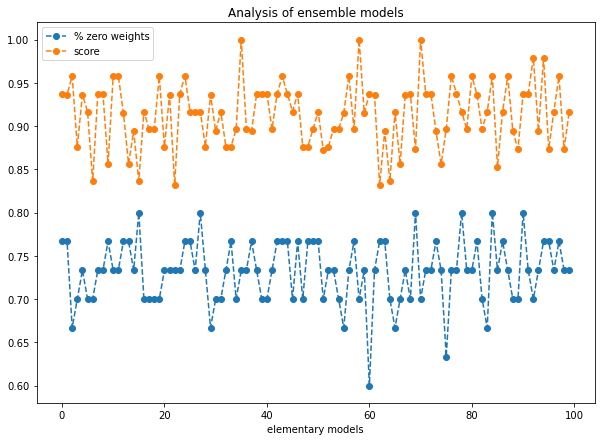

In [17]:
model.plot_elementary_models()

### Check performance using only selected features

RENT selected some features based on the distribution of the weights of each feature across the ensenmble of models. Now let's check how well a model performs that uses only the selected features on unseen data, i.e data that has not been touched by the RENT method. 

In [25]:
#predict test data

# Import what is needed for prediction and evaluation of predictions from test set
from sklearn.metrics import f1_score, precision_score, recall_score, matthews_corrcoef, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression as LR

# Scale the data accordingly
sc = StandardScaler()
train_data_sc = sc.fit_transform(train_data.iloc[:, selected_features])
test_data_sc = sc.transform(test_data.iloc[:, selected_features])

# Train model with 
prediction_model = LR(penalty='none', max_iter=8000, solver="saga", random_state=0).\
        fit(train_data_sc, train_labels)

# Print results
print("f1 1: ", f1_score(test_labels, prediction_model.predict(test_data_sc)))
print("f1 0: ", f1_score(1 - test_labels, 1 - prediction_model.predict(test_data_sc)))
print("Accuracy: ", accuracy_score(test_labels, prediction_model.predict(test_data_sc)))
print("Matthews correlation coefficient: ", matthews_corrcoef(test_labels, prediction_model.predict(test_data_sc)))


f1 1:  0.9864253393665158
f1 0:  0.9747899159663865
Accuracy:  0.9823529411764705
Matthews correlation coefficient:  0.961297062689838


### Validation study regarding the features selected by RENT

In order to validate the selected features we benefit to know whether the selected features provide models that perform better than random. This can be done in two complementary ways, both using  Student's t-tests:

1. randomly draw the same number of features from the full set of features and compute model performance on the test data. Do this many times and collect model performances. Compute average performance across these models and check how many of those are higher than the performance of the selected features. One should expect that the average performance of the models with randomly drawn features would be substantially lower than the performance of the model with the selected features. One should also expect that the number of performances with randomly drawn features higher than the performance of the model with the selected features should be quite low. Say, if 4 out of 100 models with randomly drawn features are higher than the performance with the selected features, this would result in a heuristic p-value 4 / 100 = 0.04. It is up to the user where to set the required significance level. A one-sided student's t-test indicates whether we should reject the Null-hypothesis of RENT not being better than random feature selection.

2. permute the lables of the test data and compute model performance using the selected features every time. In the same manner as in point 1 above, collect the performances based on permuted labels and compute average performance. One should expect that the average performance for the models with permuted labels should be substantially lower. Also as in 1. one can compute the heuristic p-value from the permutation based model performances by checking how many of the models provided higher performance than the model using the original lables without permutation. Also the same student's t-test as in 1. is conducted.

A nice source on these permuation based p-values is provideded [here](https://www.jwilber.me/permutationtest/ ).

mean VS1 0.8660385198805778
VS1: p-value for average score from random feature drawing:  4.681248804260099e-23
VS1: heuristic p-value (how many scores are higher than the RENT score):  0.02
With a significancelevel of  0.05  H0 is rejected.
 
-----------------------------------------------------------
 
Mean VS2 -0.006814257659573535
VS2: p-value for score from permutation of test labels:  7.244257866755021e-109
VS2: heuristic p-value (how many scores are higher than the RENT score):  7.244257866755021e-109
With a significancelevel of  0.05  H0 is rejected.


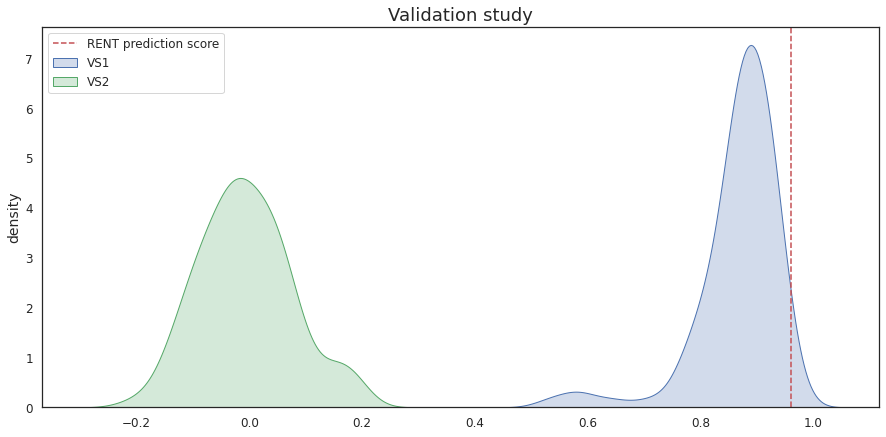

In [26]:
model.plot_validation_study(test_data, test_labels, num_drawings=100, num_permutations=100, alpha=0.05)

From the plot above and the computed p-values we can conclude that the test performance with the selected features is:

* significantly better than the average prediction performance from randomly drawn features from the full set of features
* significantly better than the average prediction performance from models with permuted test labels

This means we can be confident that we have selected relevant and important features for the model.

### Investigation of class predictions

Since we use an ensemble of models, we can predict the class of the validations samples during the RENT process. We can get more details by calling `.summery_objects()` which will return a data frame holding all predictions.

In the example below we can see that patient 0 was 21 times (out of K=100 models in the ensemble) in the validation set (column `# test`). That means we get 21 predictions from 21 unique models and investigate how well predictions worked for this patient. Patient 6 belongs to class 0 (column `class`) and was predictied incorrectly 26 times (column `# incorrect`) out of 26 predictions, which results in 100% incorrect classifications (column `% incorrect`). 

Looking at this dataframe we can see that most of the patients were predicted correctly every time, however, there are some patients that were predicted incorrectly every time (patients 6, 24, 48, 57, 95, 130, 145, 208, 287, 359). It might be worth investigating why it is so difficult predict the correct class for these patients by comparing them to patients from the same class that are predicted correctly most or all of the times. We will do this using PCA further below in this notebook.  

In [18]:
model.get_summary_objects()

,# test,class,# incorrect,% incorrect
0,21,0,0,0.000000
1,26,0,0,0.000000
2,21,0,0,0.000000
3,23,0,0,0.000000
4,21,0,0,0.000000
5,17,0,0,0.000000
6,26,0,26,100.000000
7,25,0,0,0.000000
8,25,0,0,0.000000
9,24,1,0,0.000000


We can also extract the class probabilities for each prediction by calling `.get_object_probabilities()`.

In [19]:
model.get_object_probabilities()

,mod 1,mod 2,mod 3,mod 4,mod 5,mod 6,mod 7,mod 8,mod 9,mod 10,mod 11,mod 12,mod 13,mod 14,mod 15,mod 16,mod 17,mod 18,mod 19,mod 20,mod 21,mod 22,mod 23,mod 24,mod 25,mod 26,mod 27,mod 28,mod 29,mod 30,mod 31,mod 32,mod 33,mod 34,mod 35,mod 36,mod 37,mod 38,mod 39,mod 40,mod 41,mod 42,mod 43,mod 44,mod 45,mod 46,mod 47,mod 48,mod 49,mod 50,mod 51,mod 52,mod 53,mod 54,mod 55,mod 56,mod 57,mod 58,mod 59,mod 60,mod 61,mod 62,mod 63,mod 64,mod 65,mod 66,mod 67,mod 68,mod 69,mod 70,mod 71,mod 72,mod 73,mod 74,mod 75,mod 76,mod 77,mod 78,mod 79,mod 80,mod 81,mod 82,mod 83,mod 84,mod 85,mod 86,mod 87,mod 88,mod 89,mod 90,mod 91,mod 92,mod 93,mod 94,mod 95,mod 96,mod 97,mod 98,mod 99,mod 100
0,NaN,0.001797,NaN,0.002394,NaN,0.001703,0.001330,NaN,0.001823,NaN,0.002313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001729,NaN,NaN,0.001776,NaN,NaN,NaN,NaN,0.001560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001650,NaN,NaN,0.002263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001442,0.002487,NaN,NaN,NaN,NaN,0.001466,NaN,NaN,NaN,NaN,NaN,NaN,0.001485,NaN,NaN,NaN,0.002084,NaN,0.001346,NaN,0.003061,NaN,NaN,0.002257,0.002970,NaN,NaN,NaN,NaN,NaN,0.002869,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.042457,NaN,0.039376,NaN,NaN,0.036118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.048437,0.030633,NaN,NaN,NaN,0.037165,NaN,NaN,NaN,NaN,NaN,NaN,0.045106,NaN,NaN,NaN,0.031976,0.030318,0.047591,NaN,NaN,NaN,0.039264,0.035726,0.042115,NaN,NaN,NaN,0.047137,NaN,0.038288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.041510,NaN,NaN,NaN,NaN,NaN,0.039396,NaN,0.050346,NaN,NaN,NaN,NaN,NaN,0.045204,NaN,NaN,NaN,0.032011,NaN,NaN,NaN,NaN,NaN,0.025680,0.038955,NaN,NaN,0.026013,NaN,NaN,NaN,NaN,NaN,NaN,0.038542,NaN,NaN,NaN,0.033095,NaN,NaN,NaN,NaN,NaN,0.044341
2,NaN,0.007623,NaN,NaN,NaN,NaN,0.005601,NaN,NaN,NaN,NaN,NaN,NaN,0.008571,NaN,NaN,NaN,0.006709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009210,0.008458,NaN,NaN,NaN,0.006798,NaN,NaN,NaN,NaN,0.005246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007897,0.008174,NaN,NaN,NaN,0.008210,NaN,NaN,NaN,NaN,0.007705,0.006304,NaN,NaN,NaN,NaN,NaN,0.006368,NaN,NaN,NaN,NaN,0.007305,NaN,NaN,0.007309,NaN,NaN,NaN,NaN,NaN,NaN,0.007551,NaN,NaN,NaN,NaN,NaN,NaN,0.007148,NaN,NaN,NaN,0.007872,NaN,NaN,NaN,NaN,NaN,NaN,0.008439,0.009892,NaN
3,0.363023,NaN,NaN,0.306608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.372278,NaN,NaN,NaN,0.413783,NaN,NaN,NaN,NaN,0.357772,NaN,NaN,NaN,NaN,0.318666,NaN,NaN,0.340152,0.381171,0.317764,NaN,0.373917,NaN,0.379482,NaN,NaN,NaN,0.302815,NaN,0.361250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.342332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.408654,NaN,NaN,NaN,NaN,NaN,0.346629,NaN,NaN,0.314929,NaN,NaN,0.367810,0.359283,0.353073,0.321780,NaN,NaN,NaN,NaN,0.277483,NaN,NaN,NaN,0.305317,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,0.081948,NaN,0.117816,0.096299,NaN,NaN,0.079885,NaN,NaN,NaN,NaN,0.079183,NaN,0.061736,0.077353,NaN,0.080868,NaN,NaN,0.057601,NaN,NaN,NaN,0.068792,0.076517,NaN,NaN,0.106779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.077682,NaN,NaN,NaN,0.057212,NaN,NaN,NaN,NaN,NaN,NaN,0.071917,NaN,NaN,NaN,0.077091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.083161,NaN,0.095416,NaN,NaN,NaN,0.079906,NaN,NaN,NaN,0.052128,NaN,NaN,NaN,0.068876,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,0.103934,NaN,NaN,NaN,0.093313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.093206,NaN,NaN,NaN,NaN,NaN,NaN,0.111732,0.086469,NaN,NaN,NaN,0.111316,NaN,NaN,NaN,NaN,NaN,0.114784,NaN,NaN,0.099602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.093872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.076220,NaN,NaN,NaN,NaN,0.093582,NaN,0.096584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.113718,NaN,NaN,0.088441,NaN,NaN,NaN,NaN,NaN,0.123279,NaN,0.103663,NaN,0.107494
6,NaN,NaN,NaN,NaN,NaN,0.573092,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.610407,NaN,NaN,NaN,0.552708,NaN,NaN,0.627225,0.585770,0.608262,NaN,0.555448,NaN,0.632361,NaN,NaN,NaN,0.584476,0.637295,0.645066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.600211,NaN,NaN,

We can plot the class probabilities for one or more patients by calling `.plot_object_probabilities` and investigate how difficult it was to classify the patients correctly. Patients 3 (class 0) was always predicted correctly. For patient 6, who belongs to class 0, 100% of the class probabilities indicate incorrectly that this patient belongs to class 1. Patients 121 (class 0) and 376 (class 1) seem to be hard to classify. Most of the predictions are around 0.5, indicating that the class affiliation is very unclear.

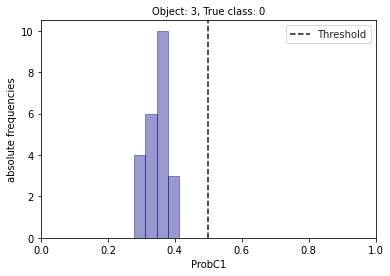

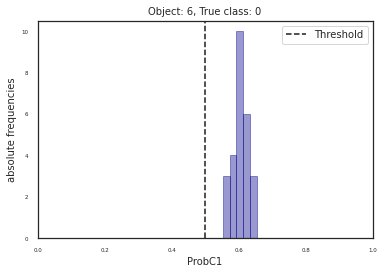

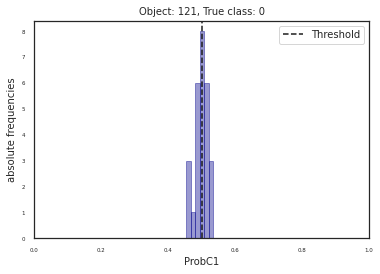

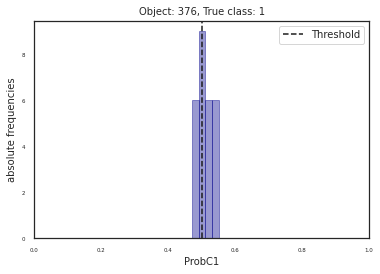

In [20]:
model.plot_object_probabilities(object_id=[3,6,121,376])

We can apply PCA (principal component analysis) either on each class separately or both. 

**Example below: PCA on class 0**

* First plot: *PCA scores* plot with coloured scores showing distribution of the patients for the first two components.

Each point represents one patient in the class. The darker the colour, the more often the patient was classified incorrectly. The coloring degree is set by the value in column `% incorrect` in the array above that we got when calling `.get_summary_objects()`. When applying PCA to class 0 we can see that patients which are often classified incorrectly are grouped on the lower left side of the scores plot, indicating that they are similiar in some way.  

* Second plot: *PCA scores* plot - same as first plot, now showing patient ID

We can see that the first component explains 50.3% of the total variance in the data based on the six selected features, while the second component explains 24%. That means that the first and second component together explain 74.3% of all the total variance. We have captured much of the systematic information with these two components, however more systematic information may be containten in further components, i.e. component 3, 4 and so on. One has to keep in mind though, that the explained variance is smaller for each following component.

* Third plot: *PCA loadings* plot showing how features contributed to the variance in the data

Five of the six selected features are located on the right ($\geq 0$ on the first axis) side of the plot. When superimposing the PCA scores plot on PCA loadings plot we can say the following: patients in close proximity of the features have high values for those features. Patients on the opposite side have low values for those features. From the two plots we can say that the misclassified patients had relatively low values for the selected features. 

* Fourth plot: *PCA correlation loadings* plot - similar to *PCA loadings* plot, but showing how much of the variance is explained in each feature

We can see that the variance in features `F8`, `F21`, `F23`, `F25` and `F28` is explained almost entirely by component 1 and 2, since they are located close to the outer ring that represents 100% explained variance. The inner ring represents 50% explained variance. For features `F8`, `F21`, `F23` almost all of the explained variance is captured by component 1. For features `F25` and `F28` it is the combination of component 1 and 2 that contribute to explaining close to 100% of the variance. Feature `F22` is now well explained by component 1 and 2, meaning that some of its systematic variance may be explained by component 3 or further.  

* Fifth plot: *PCA bi-plot* - superimposed *PCA scores* and *PCA loadings*

The bi-plot superimposes the PCA scores and PCA loadings.

* Sixth plot: *PCA explained variance*

The plot shows the cumulative explained variance across an increasing number of components. The blue line represents the calibrated explained variance, while the red line represents the validated explained variance. The red line being close to the blue line indicates that all components in the model are valid and may be used for interpretation. We also see that six components explain 100% of all variance in the data. This is not surprising, since we have exactly six features in the the data (the six features that were selected by RENT). Though, we already get very close to 100% explained variance with four features.

loo


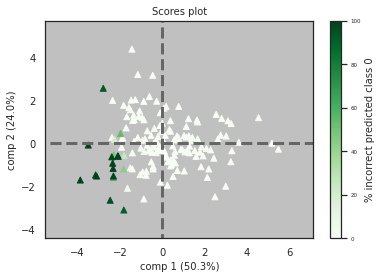

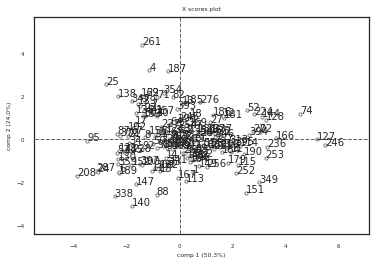

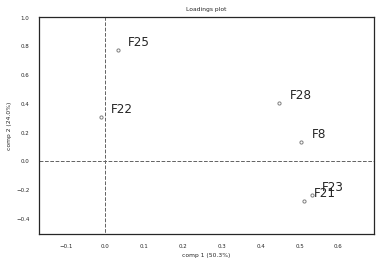

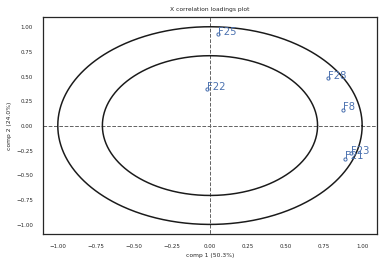

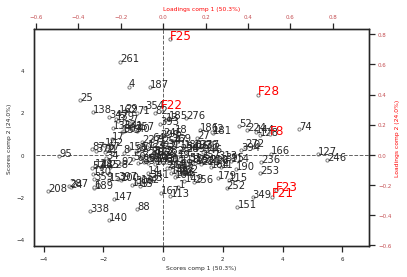

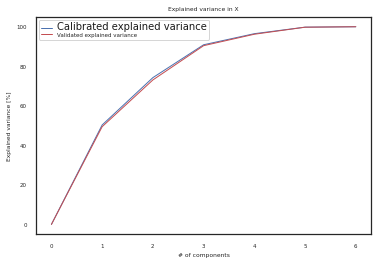

In [21]:
model.plot_object_PCA(cl=0)

**Example below: PCA on class 1**

* First plot: *PCA scores plot* with colouring

We can see that only few samples are coloured darker because of misclassification. 

loo


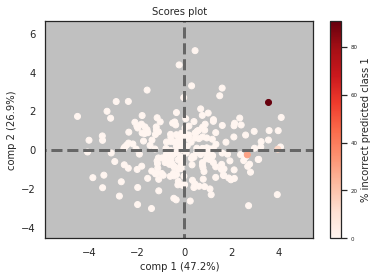

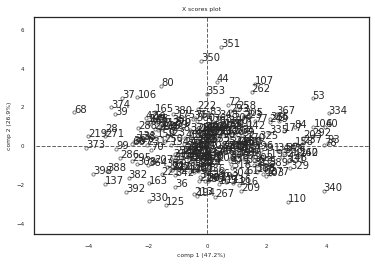

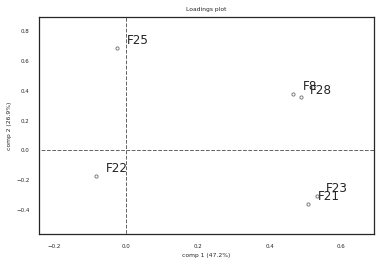

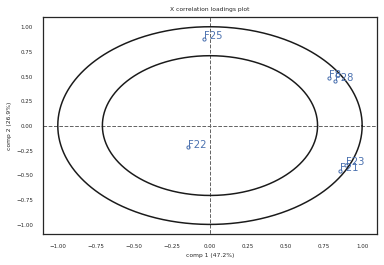

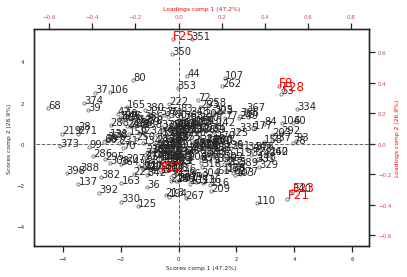

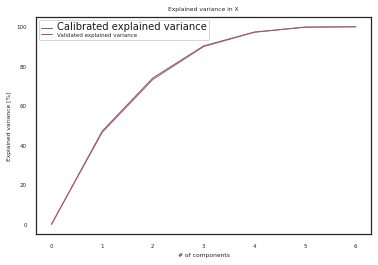

In [22]:
model.plot_object_PCA(cl=1)

**Example below: PCA on class 0 and class 1 together**

* First plot: *PCA scores* plot with coloured scores

We can see that most of the misclassified samples would lie along the dicision boundary (not shown) that separates the two classes. Circles represent class 1, while triangles represent class 0. Setting `cl="continuous` colors the first plot with regard to the average object probability for the object over the models where the object was part of a testset.  

loo


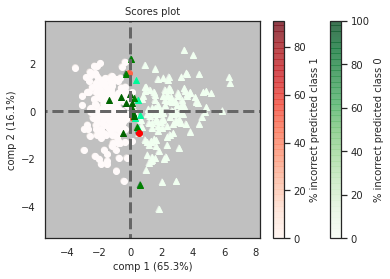

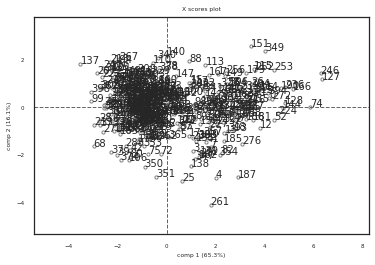

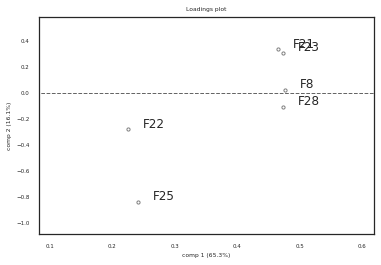

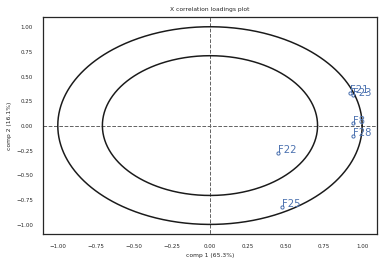

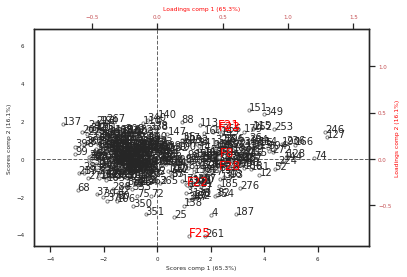

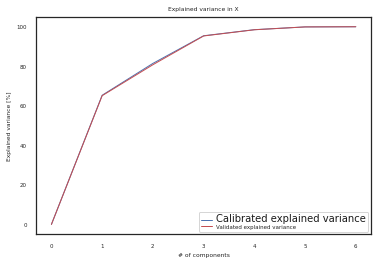

In [23]:
model.plot_object_PCA(cl='both', problem ="class")

Another possibility is to color the objects by their average prediction of belonging to class 1. We observe a gradient coloring, with 2 clusters and unstable objects with probabilities of around 0.5 in the middle. 

loo


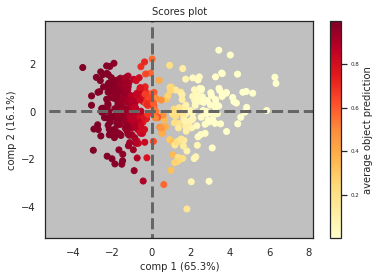

In [24]:
model.plot_object_PCA(cl='continuous', problem ="class",hoggorm=False)

### Stability analysis of RENT

To evaluate the stability of RENT we use a stability measure investiaged by Nogueira et al. We define RENT as stable, if the selected feature set is the same up to some random variability, when applying RENT multiple times (`M`) to the same dataset. 

In [27]:
import numpy as np
from sklearn.linear_model import LogisticRegression
import time


M=10 # number of runs 
alpha = 0.05 # level of significance for the confidence interval 
d = len(train_data.columns) # number of features
counts = [2, 5, 10, 50, 100, 300, 500] # values to compare (K)
C, l1 = model.get_enet_params()

# Store outputs in dictionaries
times = {}
stabilities = {}
perf = {}
num_feats = {}

start = time.time()

for count in counts:
    time_count = []
    Z_net = np.zeros((M,d), dtype=np.int8)
    performance = np.zeros(M)
    numFeatures = np.zeros(M)
    
    for i in range(M):
        model = RENT.RENT_Classification(data=train_data.values,
                                        target=train_labels,
                                        C=[C],
                                        l1_ratios=[l1],
                                        autoEnetParSel=False,
                                        poly='OFF',
                                        testsize_range=(0.25,0.25),
                                        scoring='mcc',
                                        K=count,
                                        scale=True,
                                        random_state=None,
                                        verbose=0)
        model.train()
        features = model.selectFeatures(0.9,0.9,0.975)
        time_count.append(model.get_runtime())
        
        #prediction model
        sc = StandardScaler()
        train = sc.fit_transform(train_data.values[:,features])
        test = sc.transform(test_data.values[:,features])
        ML_model = LogisticRegression(penalty='none', max_iter=8000, solver='saga').fit(train, train_labels)
        performance[i] = matthews_corrcoef(test_labels, ML_model.predict(test))
        Z_net[i,features] = 1
        numFeatures[i] = len(features)

    times[count] = time_count
    stabilities[count] = stability.confidenceIntervals(Z_net, alpha=alpha)
    perf[count] = performance
    num_feats[count] = numFeatures    

end = time.time()

print('Runtime: ', end - start, "seconds")
        

No feature names found - automatic generate feature names.
Runtime:  353.0536046028137 seconds


The following plot compares the runtime, stability and prediction performance of RENT for different numbers of models `K`. For the Wisconsin breast cancer dataset, the stability is very high for all setups. The high stability values for ``K``equals 2, 5 and 10  is a fact of random variations. 

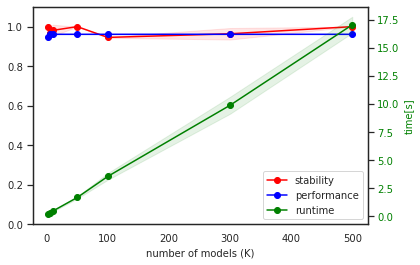

In [28]:
import matplotlib.pyplot as plt
def stability_plot(x_levels, stabilities, accuracies, times):
    stability = np.array(list({k: v['stability'] for k, v in stabilities.items()}.values()))
    stab_error = stability - np.array(list({k: v['lower'] for k, v in stabilities.items()}.values()))
    performance = np.array(list({k: np.mean(v) for k, v in accuracies.items()}.values()))
    performance_error = np.array(list({k: np.std(v) for k, v in accuracies.items()}.values()))
    runtime = np.array(list({k: np.mean(v) for k, v in times.items()}.values()))
    runtime_errors = np.array(list({k: np.std(v) for k, v in times.items()}.values())) 

    fig, ax1 = plt.subplots()
    ax1.set_xlabel('number of models (K)',fontsize=10)
    stab = ax1.plot(x_levels,stability, color="red", label='stability', marker='o')
    ax1.fill_between(x_levels, (stability-stab_error), (stability+stab_error),color="red", alpha= 0.1 )
    perf = ax1.plot(x_levels,performance, color="blue", label='performance', marker='o')
    ax1.fill_between(x_levels, (performance-performance_error), (performance+performance_error),color="blue", alpha= 0.1 )
    plt.ylim(0,1.1)
    plt.yticks(fontsize=10)
    plt.xticks(fontsize=10)
    ax2 = ax1.twinx()
    ax2.set_ylabel('time[s]', color='green', fontsize=10)
    tim = ax2.plot(x_levels,runtime, color="green", label='runtime', marker='o')
    ax2.fill_between(x_levels, (runtime-runtime_errors), (runtime+runtime_errors),color="green", alpha= 0.1)
    ax2.tick_params(axis='y', labelcolor="green")

    leg = stab + perf + tim
    labs = [l.get_label() for l in leg]
    ax1.legend(leg, labs, loc=4, fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)


stability_plot(counts, stabilities, perf, times)